# Hands-On NLP
## Class 4

<span style="color:magenta">Group Names:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

### Outline:

- Simple tokenization

- Words and indices

- Initialization

- Visualization

- Forward, cost, backward, training

- First on a sentence, then on a larger text

Main goal: understand the transformations needed to obtain vector representations

In [1]:
import doctest
import re
from collections import Counter
from datetime import datetime
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.4.0
print("pandas's version:", pd.__version__)          # 2.2.0

sklearn's version: 1.3.2
pandas's version: 1.3.5


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

In [4]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=0)

In [5]:
DATA = Path("../data/enwiki")

# ENWIKI_FP = DATA / "enwiki_20180420_100d.txt"
ENWIKI_FP = DATA / "enwiki-50k_100d-clean.txt"

EPS = np.finfo(float).eps

TOY_CORPUS = """What is a word embedding?
A word vector (or embeddings) is a dense representation,
which captures semantic relationships between words."""

In [6]:
def tokenize(text, pattern=r"\w+"):
    """Tokenize a text into a list of tokens.
    >>> tokenize("Let's do hands-on Natural Language Processing!")
    ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    """
    return re.findall(pattern, text.lower())

In [9]:
pprint(tokenize(TOY_CORPUS), compact=True)

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


In [12]:
def build_vocab(tokens, show_df=False):
    """
    🚧 TODO:
    describe types of input and output of this function
    tokens:
    vocab:
    voc2id:
    end TODO
    """
    df = pd.DataFrame(Counter(tokens).most_common(), columns=["token", "count"])
    if show_df:
        display(df)

    vocab = df.token.to_list()
    voc2idx = {word: idx for idx, word in enumerate(vocab)}

    return vocab, voc2idx

### CBOW

For the calculation of the word2vec we also have the CBOW (continuous bag of words) method as an alternative to Skipgram.
In CBOW, we try to predict the central word from the whole context of the central word.
Our xs, ys training data have fewer inputs, only as many as the text has words, but are richer.
For prediction, we sum the context vectors to predict the center.

In [28]:
def generate_cbow_data(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )
    ([[1, 2],
      [0, 2, 3],
      [0, 1, 3, 4],
      [1, 2, 4, 5],
      [2, 3, 5, 6],
      [3, 4, 6, 7],
      [4, 5, 7],
      [5, 6]],
     [0, 1, 2, 3, 4, 5, 6, 7])
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        if i < window_size:
            context = tokens[:i] + tokens[i+1: i+1+window_size]
        elif i > tokens_n - window_size:
            context = tokens[i-window_size:i] + tokens[i+1:]
        else:
            context = tokens[i-window_size:i] + tokens[i+1:i+1+window_size]

        xs.append([voc2idx[word] for word in context])
        ys.append(voc2idx[tokens[i]])
        

    return xs, ys

In [29]:
#Proof that it is correct
generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )

([[1, 2],
  [0, 2, 3],
  [0, 1, 3, 4],
  [1, 2, 4, 5],
  [2, 3, 5, 6],
  [3, 4, 6, 7],
  [4, 5, 7],
  [5, 6]],
 [0, 1, 2, 3, 4, 5, 6, 7])

### Skipgram

In [40]:
def generate_skip_data(tokens, window_size):
    """
    create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    >>> tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    >>> xs, ys = generate_skip_data(tokens, window_size=2)
    >>> print(len(xs[0]), len(ys[0]))
    26 26
    >>> print(xs)
    [[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
    >>> print(ys)
    [[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        if i < window_size:
            context = tokens[:i] + tokens[i+1: i+1+window_size]
        elif i > tokens_n - window_size:
            context = tokens[i-window_size:i] + tokens[i+1:]
        else:
            context = tokens[i-window_size:i] + tokens[i+1:i+1+window_size]

        for word in context:
            xs.append(voc2idx[tokens[i]])
            ys.append(voc2idx[word])
    return [xs], [ys]

In [41]:
#Proof that the implementation is correct
tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
xs, ys = generate_skip_data(tokens, window_size=2)
print(len(xs[0]), len(ys[0]))
print(xs)
print(ys)

26 26
[[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
[[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]


In [42]:
# let's test these functions:
tokens = tokenize(TOY_CORPUS)
pprint(tokens, compact=True)

vocab, voc2idx = build_vocab(tokens, show_df=True)

xs, ys = generate_cbow_data(tokens, 3)
print(len(xs), len(ys))
xs

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


,token,count
0,a,3
1,is,2
2,word,2
3,what,1
4,embedding,1
5,vector,1
6,or,1
7,embeddings,1
8,dense,1
9,representation,1


20 20


[[1, 0, 2],
 [3, 0, 2, 4],
 [3, 1, 2, 4, 0],
 [3, 1, 0, 4, 0, 2],
 [1, 0, 2, 0, 2, 5],
 [0, 2, 4, 2, 5, 6],
 [2, 4, 0, 5, 6, 7],
 [4, 0, 2, 6, 7, 1],
 [0, 2, 5, 7, 1, 0],
 [2, 5, 6, 1, 0, 8],
 [5, 6, 7, 0, 8, 9],
 [6, 7, 1, 8, 9, 10],
 [7, 1, 0, 9, 10, 11],
 [1, 0, 8, 10, 11, 12],
 [0, 8, 9, 11, 12, 13],
 [8, 9, 10, 12, 13, 14],
 [9, 10, 11, 13, 14, 15],
 [10, 11, 12, 14, 15],
 [11, 12, 13, 15],
 [12, 13, 14]]

In [43]:
ys

[3, 1, 0, 2, 4, 0, 2, 5, 6, 7, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15]

In [44]:
xs, ys = generate_skip_data(tokens, 3)
xs, ys = np.array(xs), np.array(ys)
print(xs.shape, ys.shape)
print(xs)

(1, 108) (1, 108)
[[ 3  3  3  1  1  1  1  0  0  0  0  0  2  2  2  2  2  2  4  4  4  4  4  4
   0  0  0  0  0  0  2  2  2  2  2  2  5  5  5  5  5  5  6  6  6  6  6  6
   7  7  7  7  7  7  1  1  1  1  1  1  0  0  0  0  0  0  8  8  8  8  8  8
   9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12
  13 13 13 13 13 14 14 14 14 15 15 15]]


In [45]:
print(ys)

[[ 1  0  2  3  0  2  4  3  1  2  4  0  3  1  0  4  0  2  1  0  2  0  2  5
   0  2  4  2  5  6  2  4  0  5  6  7  4  0  2  6  7  1  0  2  5  7  1  0
   2  5  6  1  0  8  5  6  7  0  8  9  6  7  1  8  9 10  7  1  0  9 10 11
   1  0  8 10 11 12  0  8  9 11 12 13  8  9 10 12 13 14  9 10 11 13 14 15
  10 11 12 14 15 11 12 13 15 12 13 14]]


In [48]:
vocab, voc2idx = build_vocab(tokens)
vocab_size = len(vocab)
ys = np.array(ys)
m = np.array(ys).shape[1]

# ys in one-hot encoding:
one_hot_ys = np.zeros((vocab_size, m))
one_hot_ys[ys.flatten(), np.arange(m)] = 1  # important to understand for later!
one_hot_ys.shape  # can you explain the shape?

(16, 108)

### 🚧 TODO:

*   Explain why there are three 3's, four 1's... in `xs`

*   Explain why there are more 0's than, e.g., 3's in `ys`

The number of times each index appears in xs is the amount of words that the central word has in its context. Doing that, each index of the context (ys) is associated with a unique element of the xs array.

Index = 0 represent the word 'a' that appears 3 times in the text so it will appear in more context than for example index 3 ('what') which just appears once so the amount of context (depending on the window_size value) will be lower. So, the more occurrence of a word in a text, the more it index appears in ys.

In [49]:
def initialize_embeddings(vocab_size, emb_size, seed=None):
    """
    vocab_size (int): vocabulary size of your corpus or training data
    emb_size (int): word embedding size (dimensions to represent each word)
    returns a matrix of size (vocab_size, emb_size)
    🚧 TODO: complete the "_____"
    returns a matrix of shape: (vocab_size, emb_size)
    each row corresponds to the word embedding of a word in the vocabulary
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(vocab_size, emb_size))

Check out the parameters in the doc: [np.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

In [50]:
def initialize_dense(input_size, output_size, seed=None):
    """
    input_size (int): size of the input to the dense layer
    output_size (int): size of the output of the dense layer
    🚧 TODO: complete the "______"
    returns a matrix of shape : (output_size, input_size)
    each row corresponds to the weights of the dense layer
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(output_size, input_size))

In [51]:
def initialize_parameters(vocab_size, emb_size, seed=None):
    """
    Initialize all the training parameters
    """
    embs = initialize_embeddings(vocab_size, emb_size, seed)
    ws = initialize_dense(emb_size, vocab_size, seed)

    parameters = {}
    parameters["EMBS"] = embs
    parameters["W"] = ws

    return parameters

In [52]:
# for example an embedding of dimension 5
parameters = initialize_parameters(len(vocab), emb_size=5, seed=42)

In [53]:
print(parameters["EMBS"].shape, parameters["W"].shape)

(16, 5) (16, 5)


In [54]:
# We can multiply them:
(parameters["EMBS"].T @ parameters["W"]).shape

(5, 5)

In [55]:
def plot_embedding(vs, indices, vocab):
    pca = PCA(n_components=2)
    data = pca.fit_transform(vs).transpose()
    xs, ys = data[0], data[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(xs, ys, c="green")
    for i, idx in enumerate(indices):
        ax.annotate(
            vocab[idx], (xs[i], ys[i]), xytext=(5, 5), textcoords="offset points"
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("2 dimensions of the word embeddings")
    plt.show()

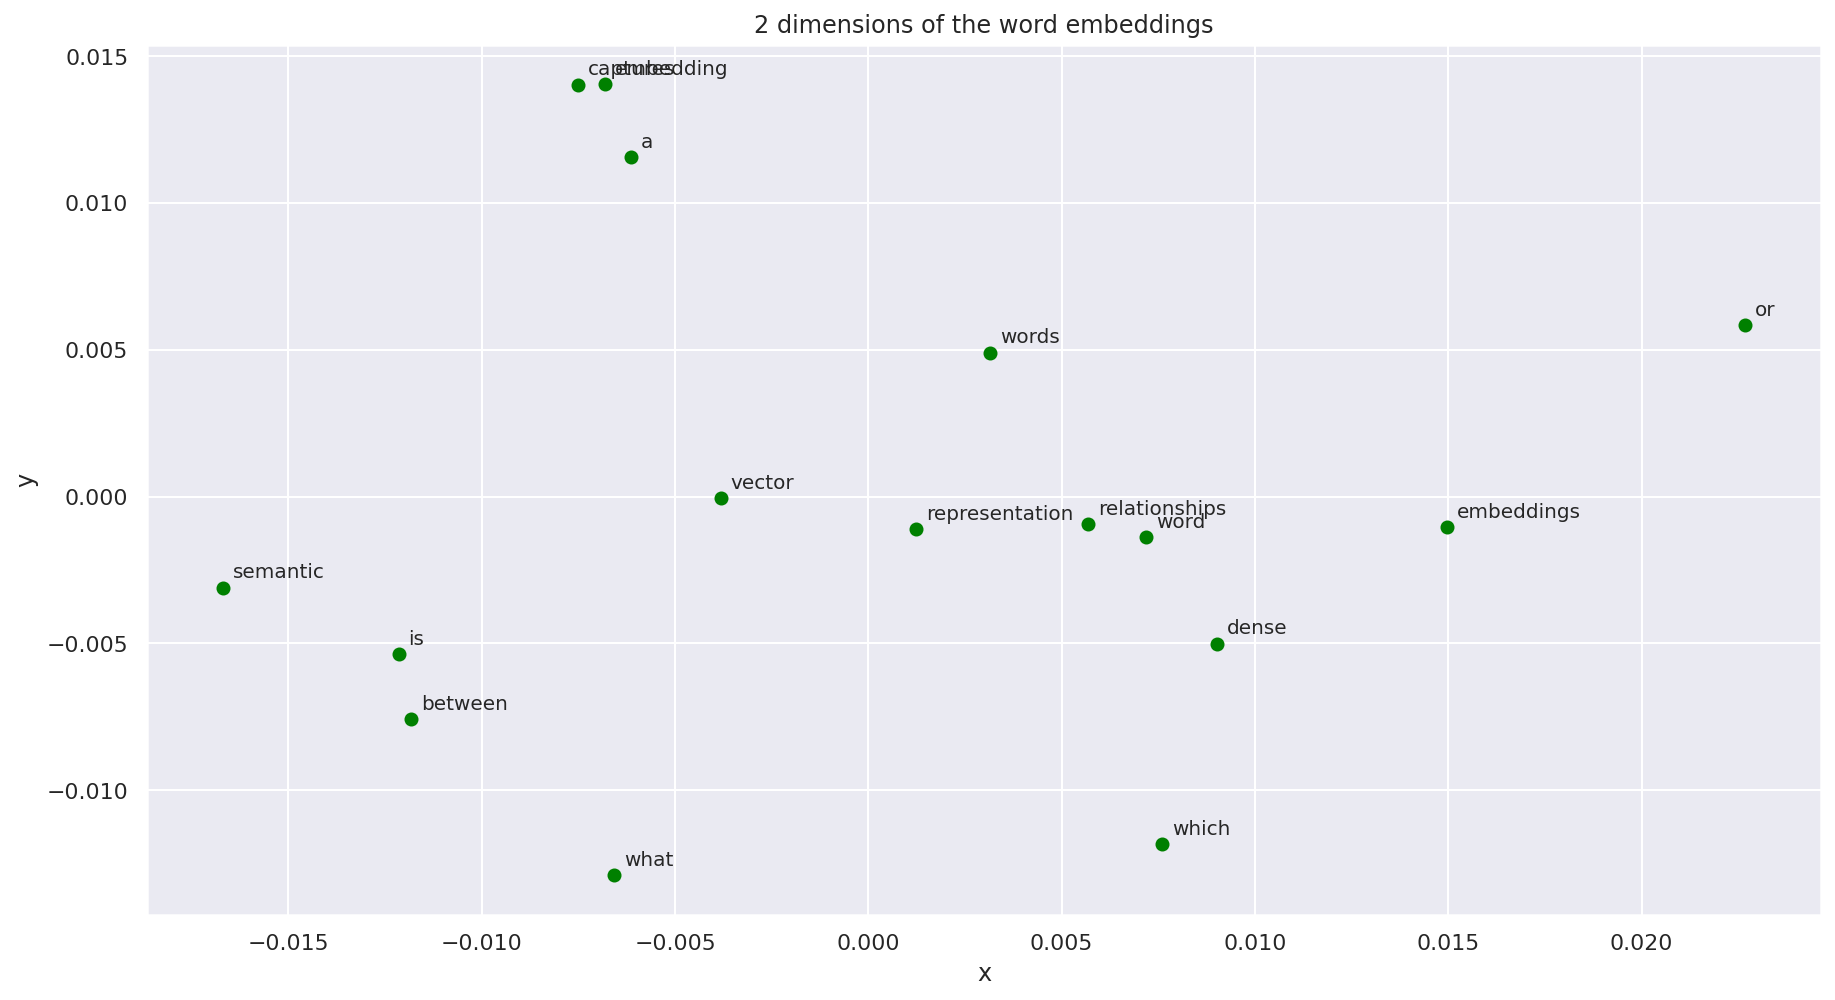

In [56]:
# plotting all the words that have just been initialized:
# print(parameters["emb"].shape)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [57]:
def ind_to_word_embs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained

    🚧 TODO: complete:
    returns a matrix of word vectors as _____ columns with shape _____
    end TODO

    """
    m = inds.shape[1]
    embs = parameters["EMBS"]

    # Select the rows of the embedding matrix corresponding to the indices
    #     flatten() -> 1D array (as many elements as indices)
    w_embs = embs[inds.flatten(), :].T

    assert w_embs.shape == (embs.shape[1], m)

    return w_embs

In [58]:
def linear_dense(w_embs, parameters):
    """
    w_embs: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    returns: ws et zs
    ws: matrix of weights of the dense layer
    zs: output matrix of the dense layer
        🚧 TODO: complete :
        zs is of shape: _____

    """
    m = w_embs.shape[1]
    ws = parameters["W"]
    zs = np.dot(ws, w_embs)

    assert zs.shape == (ws.shape[0], m)

    return ws, zs

In [59]:
def softmax(zs):
    """
    zs: output out of the dense layer.
        shape: (vocab_size, m = number of input vectors (tokens to update))
    """
    softmax_out = np.divide(
        np.exp(zs), np.sum(np.exp(zs), axis=0, keepdims=True) + EPS
    )
    assert softmax_out.shape == zs.shape

    return softmax_out

In [60]:
def forward_propagation(inds, parameters):
    w_embs = ind_to_word_embs(inds, parameters)
    ws, zs = linear_dense(w_embs, parameters)
    softmax_out = softmax(zs)

    caches = {}
    caches["inds"] = inds
    caches["w_embs"] = w_embs
    caches["W"] = ws
    caches["Z"] = zs
    return softmax_out, caches

In [61]:
def cross_entropy(softmax_out, ys):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    ys: ground truth: indices à prédire. shape: (1, m)
    """
    m = softmax_out.shape[1]

    cost = -(1 / m) * np.sum(
        np.log(softmax_out[ys.flatten(), np.arange(ys.shape[1])] + EPS)
    )
    return cost

🚧 TODO, read this carrefully:

* From the softmax out, I select the lines corresponding to the predicted tokens

* It gives me the probabilities, I take the log, and I average it

* If the prediction was perfect, the probability would be 1, the log is 0 --> zero cost

* If not, I have a proba smaller than 1, I take the average of these probas logs (which are all negative)

* With the "$-$" it becomes positive, so it is a measure of the error of the prediction

* Note that `ys` can contain several times the same index to predict. It is counted as many times as it should be predicted.

$$\frac{dL}{dZ} = softmax\_out - ys$$

$$\frac{dL}{dW} = \frac{dL}{dZ}\times\frac{dZ}{dW}= \frac{dL}{dZ}\times w\_embs.T$$

$$ 
\frac{dL}{d w\_embs} = \frac{dL}{dZ}\times\frac{dZ}{d w\_embs}
    = \frac{dL}{dZ} \times W.T
$$

In [ ]:
def softmax_backward(ys, softmax_out):
    """
    ys: labels of training data. shape: (1, m=batch_size)
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    """
    m = ys.shape[1]

    # we compute the difference between the prediction and the ground truth (ys)
    # if the prediction was perfect, the dl_dz becomes 0
    # we only touch the lines to predict
    # if the token is not to be predicted, we do not touch the line
    softmax_out[ys.flatten(), np.arange(m)] -= 1.0
    dl_dz = softmax_out

    assert dl_dz.shape == softmax_out.shape
    return dl_dz

In [ ]:
def dense_backward(dl_dz, caches):
    """
    dl_dz: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    dl_dz has negative values where something needs to be changed.
    the more negative they are, the worse it is.
    """
    ws = caches["W"]
    w_embs = caches["w_embs"]
    m = w_embs.shape[1]

    # we multiply where we need to change something:
    # dl_dz.shape = (vocab_size, m)
    dl_dw = (1 / m) * np.dot(dl_dz, w_embs.T)
    dl_dw_embs = np.dot(ws.T, dl_dz)

    assert ws.shape == dl_dw.shape
    assert w_embs.shape == dl_dw_embs.shape

    return dl_dw, dl_dw_embs

In [ ]:
def backward_propagation(ys, softmax_out, caches):
    dl_dz = softmax_backward(ys, softmax_out)
    dl_dw, dl_dw_embs = dense_backward(dl_dz, caches)

    gradients = dict()
    gradients["dL_dZ"] = dl_dz
    gradients["dL_dW"] = dl_dw
    gradients["dL_dw_embs"] = dl_dw_embs

    return gradients

In [ ]:
def update_parameters(parameters, caches, gradients, learning_rate):
    """
    here we update the embedding
    """
    vocab_size, emb_size = parameters["EMBS"].shape
    inds = caches["inds"]
    embs = parameters["EMBS"]
    dl_dw_embs = gradients["dL_dw_embs"]
    m = inds.shape[-1]

    # note that only the lines corresponding to the central words are modified
    embs[inds.flatten(), :] -= dl_dw_embs.T * learning_rate

    parameters["W"] -= learning_rate * gradients["dL_dW"]

In [ ]:
def skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size,
    learning_rate,
    epochs,
    batch_size=256,
    parameters=None,
    print_cost=False,
    plot_cost=True,
):
    costs = []
    m = xs.shape[1]

    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)

    # for the moment these three variables are not used
    # 🚧 TODO: use these variables to keep the best model at the end
    best_epoch = 0
    min_epoch_cost = float("inf")
    parameters["best_embeddings"] = parameters["EMBS"]

    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            batch_xs = xs[:, i : i + batch_size]
            batch_ys = ys[:, i : i + batch_size]

            softmax_out, caches = forward_propagation(batch_xs, parameters)
            cost = cross_entropy(softmax_out, batch_ys)
            gradients = backward_propagation(batch_ys, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += cost

        costs.append(epoch_cost)
        # 🚧 TODO: add here the code to keep the best_embeddings
        if epoch_cost < min_epoch_cost:
            ...
        # end TODO

        if print_cost and epoch % 200 == 0:
            print(f"Cost after epoch {epoch:4d}: {epoch_cost:.4f}")
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print(f"training time: {end_time - begin_time}")
    print(
        f"🚧 TODO I've kept the embedding of epoch {best_epoch} "
        f"with cost {min_epoch_cost:.4f}."
    )
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
    return parameters

In [ ]:
print(ys.shape, xs.shape, one_hot_ys.shape)

In [ ]:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=3000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)
# test with a small batch_size to see....

####  🚧 TODO:

- Keep the best model

- Visualize also the best model

### First intrinsic evaluation

- Let's take the indices of all the words

- Send them into the grinder

- See if the system can predict the words that were close as the most probable

In [ ]:
test_xs = np.arange(vocab_size)
print(test_xs, test_xs.shape)
test_xs = np.expand_dims(test_xs, axis=0)
print(test_xs, test_xs.shape)

# 🚧 TODO: complete

# send test_xs to the forward_propagation
softmax_test, _ = ...

# find the 5 most likely indices:
top_sorted_inds = np.argsort(...

# end TODO

top_sorted_inds

In [ ]:
for input_ind in range(vocab_size):
    input_word = vocab[input_ind]
    output_words = [
        vocab[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]
    ]  # explain ::-1 in few words
    print(f"{input_word}'s neighbor words: {output_words}")

In [ ]:
plot_embedding(parameters["best_embeddings"], test_xs[0], vocab)

In [ ]:
parameters["best_embeddings"].shape

In [ ]:
# Let's calculate the cosine distance between all words

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
cos_dists.shape
vocab

In [ ]:
def costs_heatmap(costs, vocab):
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        costs,
        annot=costs.round(1),
        xticklabels=vocab,
        yticklabels=vocab,
        cmap="RdPu",
    )

In [ ]:
costs_heatmap(cos_dists, vocab)

In [ ]:
### 🚧 attempt a short hande-waving explanations of what you see in the heatmap

## A longer text

In [ ]:
text = """The celestial sphere is an imaginary projection of the Sun, Moon,
planets, stars, and all astronomical bodies upon an imaginary sphere surrounding
Earth. Although originally developed as part of the ancient Greek concept of an
Earth-centered (geocentric) universe, the hypothetical celestial sphere gives
astronomers an important tool for fixing the location and plotting movements of
celestial objects. Ancient Greek astronomers envisioned concentric crystalline
spheres centered around Earth, upon which the Sun, Moon, planets, and stars
moved. Although heliocentric (Sun-centered) models of the universe were also
proposed by the Greeks, they were disregarded as counterintuitive to the
apparent motions of celestial bodies across the sky. Corresponding to Earth’s
rotation, the celestial sphere rotates through 1° in about four minutes. Because
of this, sunrise, sunset, moonrise, and moon-set, all take approximately two
minutes because both the Sun and Moon have the same apparent size on the
celestial sphere (about 0.5°). The Sun is, of course, much larger, but the Moon
is much closer. """

### Do the same thing again

for this larger text

In [ ]:
tokens = tokenize(text)
print(Counter(tokens))

vocab, voc2idx = build_vocab(tokens, show_df=True)
xs, ys = generate_skip_data(tokens, 3)

xs, ys = np.array(xs), np.array(ys)
vocab_size = len(vocab)

m = ys.shape[1]
print("m:", m)

In [ ]:
# Initialize the parameters and visualize the distribution (normal, random)
parameters = initialize_parameters(len(vocab), 5)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [ ]:
# Be patient:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=5000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)

In [ ]:
# 🚧 TODO: as before find the predicted words from the context
test_xs = np.arange(vocab_size)
test_xs = np.expand_dims(test_xs, axis=0)
softmax_test, _ = forward_propagation(...
top_sorted_inds = np.argsort(...
for input_ind in range(10):
    ...
    print(f"{input_word}'s neighbor words: {output_words}")

In [ ]:
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [ ]:
# very (!) slow and not very telling as it is.
# optional TODO : who can reduce the heatmap to a few frequent words?

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
costs_heatmap(cos_dists, vocab)

### Conclusions:

- It works, but we would like to train on a much larger corpus

  - For that, we should:
  
    - Not exceed the lines when computing the neighborhood
  
    - Use negative sampling
  
    - Maybe implement a part in C and optimized for graphic card -- 
      or use a deep learning module (PyTorch, TensorFlow...)

- We will rely on an already implemented module: **Gensim**

→ Next section

____________

### 🌸 Gensim Word Embedding

- Word embedding
 
  - 🚧 TODO: complete a function to read a pre-computed embedding
 
  - 🚧 TODO: normalize vectors
 
  - 🚧 TODO: complete the function that finds the closest words by cosine distance
 
  - 🚧 TODO: test the nearest words
 
  - 🚧 mini-TODO: complete and test the function that computes analogies to see if our plotting is biased

- Later: text classification

  - 🚧 TODO: find and remove an outlier in our texts (to understand that the method works very well if the texts are very different)

  - Optional TODO: other methods than k-nearest neighbors

  - Optional TODO: redo based on keywords only

All TODOs are marked with the symbol 🚧 

#### Load the pre-calculated word2vec 
  
  - Get `enwiki-50k_100d-clean.txt` here and put it next to your notebook 
    (recommended: `../data/enwiki/`)
  
  - It consists in a reduction to the 50k most frequent types of the full word2vec [pretrainded](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) on the complete English Wikipedia.  
  
    In particular this [file](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)
  
  - Open the file and explore the format
  
  - 🚧 Write a `read_vectors` function that gives a numpy matrix `embeddings` with one row per type (~ one word), each row represents the word. `embeddings[i, :]` corresponds to one type.

In [ ]:
# # comment out once the file is downloaded or taken manually
# !wget --no-check-certificate https://gerdes.fr/saclay/enwiki-50k_100d.zip
# !unzip enwiki-50k_100d.zip

In [ ]:
# # extraction from big embedding
# c = 0
# with (
#     open("enwiki-50k_100d.txt") as in_f,
#     open("enwiki-50k_100d-clean.txt", "W") as out_f,
# ):
#     for row in in_f:
#         if c == 0:
#             c += 1
#             # continue
#         if not row.strip().startswith("ENTITY/"):
#             out_f.write(row)
#             c += 1
#         if c > 50000:
#             break

In [ ]:
def read_vectors(infile, vocab_size=50000, dimension=100):
    """
    function that reads a backup of an embedding
    returns
    - a word dictionary type -> index
    - the inverse dictionary
    - a matrix containing a vector of words per word type
    check the file to understand the format
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}  # as before
    i = 0
    for line in open(infile):
        # 🚧 TODO:
        # ...
        splitted = line.strip().split()
        w2i[...
        i2w[...
        embeddings[i] = np.array(...
        i += 1
        # end TODO
    assert len(w2i) == len(i2w) == len(embeddings)
    return w2i, i2w, embeddings

In [ ]:
w2i, i2w, embeddings = read_vectors(ENWIKI_FP)

print(len(w2i), len(i2w), embeddings.shape)

### Objectives

We want to make a python function that for a given word returns the K nearest (semantic) neighbors

To do this, we need to 

1. calculate the cosine distance between them

2. order the distances by decreasing orders


#### 1. Calculating the cosine distance
**Hint**, we can do this in two substeps: 
- 🚧 normalize the embeddings (with respect to the rows, i.e., each word vector to a unit norm)
- 🚧 calculate scalar product between the source word embedding with the whole embedding space

In [ ]:
# 🚧 TODO: normalize the embeddings (with respect to the lines,
#     i.e. each word vector to a unit norm)

# normed_embeddings = # 🚧 TODO: ...??

**⚠ Achtung!!!**:

- To simplify the calculations later, we will base our calculations on the `normed_embeddings` matrix. Thus, we won't need to divide the dot product of the two vectors by their norms (the cosine similarity of two unit vectors is just the dot product of the vectors).

- If you want to perform a similarity calculation based on another measure (Euclidean distance?), then you will have to base your calculations on the raw `embeddings` matrix (which is not normalized!)

In [ ]:
def find_closest_words_from_vector(vector, k_max=10):
    """For a given vector, find the K nearest semantic neighbors"""
    closest_words = []

    cosine_similarities = np.dot(...
    # cosine_similarities = # 🚧 TODO: ...?? think of the scalar product

    sorted_indexes = ...  # matrix sorted from smallest to largest
    # sorted_indexes =    # 🚧 TODO: ...?? matrix sorted from smallest to largest

    # Only K largest is of interest to us
    for k in range(1, k_max + 1):  # to take the last elements, we start with -1
        # 🚧 TODO: ...??
        neighboor_index = ...
        closest_words.append(...
        # end TODO
    return closest_words

In [ ]:
def find_closest_words_from_word(word, k_max=10):
    """For a given word 'word', find the K nearest semantic neighbors"""
    word_index = w2i[word]
    word_vector = normed_embeddings[word_index]
    closest_words = find_closest_words_from_vector(word_vector, k_max)
    return closest_words

In [ ]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word, similarity in closest_words:
        print(word.ljust(15, " "), similarity.round(3))
    print("___\n")

In [ ]:
# Creative time! Let's test our function on some terms
pretty_show(find_closest_words_from_word("french"))
pretty_show(find_closest_words_from_word("what"))
# trained on Wikipédia. --> few swear words... (e.g., holy ...)
pretty_show(find_closest_words_from_word("holy"))
pretty_show(find_closest_words_from_word("cool"))

### Analogies

Finally the pretty analogies in the embeddings!

In [ ]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: the first positive word
    wpos2: the 2nd positive word
    wneg: the negative word
    Find the analog "analog" such that
        <"analog" is to "wpos2" what "wneg" is to "wpos1">
    For example: <"queen" is to "woman" what "king" is to "man">
    """
    # add the positive vectors, substract the negative vector:
    # vector_analog  = ... # 🚧 TODO
    return find_closest_words_from_vector(vector_analog)

In [ ]:
pretty_show(find_analogies("king", "woman", "man"))
pretty_show(find_analogies("nurse", "man", "woman"))  # Watch out for bias!
# 🚧 TODO: Find other "questionable" examples

# 💥 Text classification by embeddings

In [ ]:
def doc2vec(text):
    """
    The function takes a text, cuts it into tokens
    For each token, if the token is in w2i, we take its vector
    We add the vectors and renormalize
    Returns: vector of the same format as the ones we have for each word
    """
    tokens = re.findall(r"\w+", text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalised = somme / np.sqrt(np.sum(somme ** 2))
    return normalised

In [ ]:
vex = doc2vec("let's see how this works, this word2vec thing!")
vex

---